## Autoencoder

In [1]:
import copy
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import warnings
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix 
import tensorflow as tf
from tensorflow import keras
# from sklearn.model_selection import train_test_split

warnings.filterwarnings('ignore')

In [2]:
complete_list = ['timestamp', 'lossOrNot']
selected_features_list_removing_correlation = [
    'interarrival_std',
    'interarrival_min',
    'interarrival_max',
    'interarrival_skew',
    'interarrival_moment4',
    'interarrival_max_min_R',
    'interarrival_max_value_count_percent',
    'len_udp_moment4',
    'len_udp_max_min_diff',
    'len_udp_max_value_count_percent',
    'inter_time_sequence_std'
]
complete_list.extend(selected_features_list_removing_correlation)

full_features_list = []
for feature in selected_features_list_removing_correlation:
    for i in range(1,11):
        col_title = f'{feature}_minus_{500*i}ms'
        full_features_list.append(col_title)

In [3]:
shrink_feature_list = []
for feature in selected_features_list_removing_correlation:
    for i in range(1, 8):
        col_title = f'{feature}_minus_{500*i}ms'
        shrink_feature_list.append(col_title)

In [4]:
# load the entire dataset

df_complete_with_features_final = pd.read_csv('models/df_final_label_feature.csv')

In [5]:
df_complete_with_features_final

,timestamp,lossOrNot,group_id,interarrival_std_minus_500ms,interarrival_std_minus_1000ms,interarrival_std_minus_1500ms,interarrival_std_minus_2000ms,interarrival_std_minus_2500ms,interarrival_std_minus_3000ms,interarrival_std_minus_3500ms,...,inter_time_sequence_std_minus_500ms,inter_time_sequence_std_minus_1000ms,inter_time_sequence_std_minus_1500ms,inter_time_sequence_std_minus_2000ms,inter_time_sequence_std_minus_2500ms,inter_time_sequence_std_minus_3000ms,inter_time_sequence_std_minus_3500ms,inter_time_sequence_std_minus_4000ms,inter_time_sequence_std_minus_4500ms,inter_time_sequence_std_minus_5000ms
0,2020-12-14 13:34:44.500000,0.0,1,0.185914,0.111167,0.149341,0.168203,0.224819,0.287330,0.584144,...,0.362588,0.420006,0.202741,0.374366,0.419943,0.231871,0.164850,0.452376,0.182312,0.000000
1,2020-12-14 13:34:45,0.0,1,0.169699,0.185914,0.111167,0.149341,0.168203,0.224819,0.287330,...,0.204396,0.362588,0.420006,0.202741,0.374366,0.419943,0.231871,0.164850,0.452376,0.182312
2,2020-12-14 13:34:45.500000,0.0,1,0.122365,0.169699,0.185914,0.111167,0.149341,0.168203,0.224819,...,0.336296,0.204396,0.362588,0.420006,0.202741,0.374366,0.419943,0.231871,0.164850,0.452376
3,2020-12-14 13:34:46,0.0,1,0.081800,0.122365,0.169699,0.185914,0.111167,0.149341,0.168203,...,0.438010,0.336296,0.204396,0.362588,0.420006,0.202741,0.374366,0.419943,0.231871,0.164850
4,2020-12-14 13:34:46.500000,0.0,1,0.113890,0.081800,0.122365,0.169699,0.185914,0.111167,0.149341,...,0.210085,0.438010,0.336296,0.204396,0.362588,0.420006,0.202741,0.374366,0.419943,0.231871
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2028655,2020-05-13 14:59:09.000,0.0,6998,0.083744,0.075046,0.078230,0.131936,0.078184,0.058745,0.069150,...,0.213018,1.000000,0.223662,0.202375,0.839116,0.213018,0.426054,0.213018,0.213018,0.934599
2028656,2020-05-13 14:59:09.500,0.0,6998,0.083497,0.083744,0.075046,0.078230,0.131936,0.078184,0.058745,...,0.213018,0.213018,1.000000,0.223662,0.202375,0.839116,0.213018,0.426054,0.213018,0.213018
2028657,2020-05-13 14:59:10.000,0.0,6998,0.048801,0.083497,0.083744,0.075046,0.078230,0.131936,0.078184,...,0.822931,0.213018,0.213018,1.000000,0.223662,0.202375,0.839116,0.213018,0.426054,0.213018
2028658,2020-05-13 14:59:10.500,0.0,6998,0.133611,0.048801,0.083497,0.083744,0.075046,0.078230,0.131936,...,0.223662,0.822931,0.213018,0.213018,1.000000,0.223662,0.202375,0.839116,0.213018,0.426054


In [6]:
df_loss = df_complete_with_features_final[df_complete_with_features_final['lossOrNot'] > 0]
df_no_loss = df_complete_with_features_final[df_complete_with_features_final['lossOrNot'] < 1]

df_loss_shuffled = df_loss.sample(frac=1).reset_index()
df_loss_shuffled.drop(['index'], axis=1, inplace=True)
df_no_loss_shuffled = df_no_loss.sample(frac=1).reset_index()
df_no_loss_shuffled.drop(['index'], axis=1, inplace=True)

In [7]:
# only train and test

df_train = df_no_loss_shuffled.iloc[0:int(df_no_loss_shuffled.shape[0] * 0.7)]
df_train_shuffled = df_train.sample(frac=1).reset_index()
df_train_shuffled.drop(['index'], axis=1, inplace=True)

df_test = pd.concat([df_loss_shuffled, df_no_loss_shuffled.iloc[int(df_no_loss_shuffled.shape[0] * 0.7)+1: -1]])
df_test_shuffled = df_test.sample(frac=1).reset_index()
df_test_shuffled.drop(['index'], axis=1, inplace=True)

In [8]:
x_train = df_train_shuffled[shrink_feature_list]
x_test = df_test_shuffled[shrink_feature_list]
y_train = df_train_shuffled[['lossOrNot']]
y_train = y_train.astype(int)
y_test = df_test_shuffled[['lossOrNot']]
y_test = y_test.astype(int)

## Normal autoencoder

In [9]:
# define the autoencoder nn

input_layer = keras.layers.Input(shape=(77,))

encoder = keras.Sequential([
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(8, activation='relu'),
])(input_layer)

decoder = keras.Sequential([
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(77, activation='sigmoid'),
])(encoder)

autoencoder = keras.Model(inputs=input_layer, outputs=decoder)

In [10]:
autoencoder.compile(
    optimizer=tf.keras.optimizers.Adam(0.001), 
    loss=keras.losses.MeanAbsoluteError()
)

In [34]:
# use training and test set during training phase
# use test set as validation set 
# use test set to determine the threshold and check the performance based on the chosen threshold

autoencoder.fit(
    x_train, x_train,
    epochs = 10,
    batch_size = 64,
    validation_data = (x_test, x_test)
)

Epoch 1/10
21880/21880 [==============================] - 269s 12ms/step - loss: 0.0669 - val_loss: 0.0626
Epoch 2/10
21880/21880 [==============================] - 262s 12ms/step - loss: 0.0619 - val_loss: 0.0613
Epoch 3/10
21880/21880 [==============================] - 230s 11ms/step - loss: 0.0609 - val_loss: 0.0607
Epoch 4/10
21880/21880 [==============================] - 257s 12ms/step - loss: 0.0605 - val_loss: 0.0603
Epoch 5/10
21880/21880 [==============================] - 262s 12ms/step - loss: 0.0602 - val_loss: 0.0602
Epoch 6/10
21880/21880 [==============================] - 1027s 47ms/step - loss: 0.0601 - val_loss: 0.0600
Epoch 7/10
21880/21880 [==============================] - 379s 17ms/step - loss: 0.0600 - val_loss: 0.0600
Epoch 8/10
21880/21880 [==============================] - 252s 12ms/step - loss: 0.0598 - val_loss: 0.0599
Epoch 9/10
21880/21880 [==============================] - 241s 11ms/step - loss: 0.0597 - val_loss: 0.0596
Epoch 10/10
21880/21880 [===========

In [12]:
percetage = len(y_test[y_test['lossOrNot'] > 0]) / len(y_test) * 100
percetage

4.489122944388477

The threshold is:  0.13054735586487035


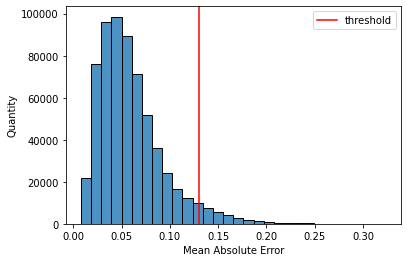

In [36]:
predictions = autoencoder.predict(x_test)
prediction_loss = keras.losses.mae(predictions, x_test)
threshold = np.percentile(prediction_loss, 100-percetage)
print('The threshold is: ', threshold)
sns.histplot(prediction_loss, bins=30, alpha=0.8)
plt.axvline(x=threshold, color='red', label='threshold')
plt.ylabel('Quantity')
plt.xlabel('Mean Absolute Error')
plt.legend()
plt.show()

Prediction Report
               precision    recall  f1-score   support

           0       0.96      0.96      0.96    600134
           1       0.05      0.05      0.05     28207

    accuracy                           0.91    628341
   macro avg       0.50      0.50      0.50    628341
weighted avg       0.91      0.91      0.91    628341



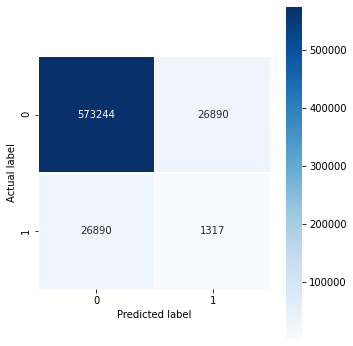

In [37]:
prediction_label = [0 if x < threshold else 1 for x in prediction_loss]
print("Prediction Report\n", classification_report(y_test, prediction_label))
cm = confusion_matrix(y_test, prediction_label)
plt.figure(figsize=(5,5))
sns.heatmap(data=cm, linewidths=.5, annot=True, square = True, cmap = 'Blues', fmt='d')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

## Autoencoder with LSTM or RNN

In [15]:
x_train_expand_ = np.expand_dims(x_train, axis = -1)
x_test_expand_ = np.expand_dims(x_test, axis = -1)\

x_train_h_dim = []
for i in range(0, x_train_expand_.shape[0]):
    datum = np.reshape(x_train_expand_[i], (7, 11))
    x_train_h_dim.append(datum)
x_train_h_dim = np.array(x_train_h_dim)

x_test_h_dim = []
for i in range(0, x_test_expand_.shape[0]):
    datum = np.reshape(x_test_expand_[i], (7, 11))
    x_test_h_dim.append(datum)
x_test_h_dim = np.array(x_test_h_dim)

In [40]:
# lstm
# define the model

my_autoencoder_lstm_model = keras.Sequential()
my_autoencoder_lstm_model.add(keras.layers.LSTM(48, input_shape=(7, 11), activation='relu', return_sequences=False))
my_autoencoder_lstm_model.add(keras.layers.Dropout(rate=0.2))
# my_autoencoder_lstm_model.add(keras.layers.LSTM(24, activation='relu', return_sequences=False))
my_autoencoder_lstm_model.add(keras.layers.RepeatVector(7))
# my_autoencoder_lstm_model.add(keras.layers.LSTM(24, activation='relu', return_sequences=True))
my_autoencoder_lstm_model.add(keras.layers.LSTM(48, activation='relu', return_sequences=True))
my_autoencoder_lstm_model.add(keras.layers.Dropout(rate=0.2))
my_autoencoder_lstm_model.add(keras.layers.TimeDistributed(keras.layers.Dense(11)))

my_autoencoder_lstm_model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001), 
    loss=keras.losses.MeanAbsoluteError()
)

In [41]:
my_autoencoder_lstm_model.fit(
    x_train_h_dim, x_train_h_dim,
    epochs = 3,
    batch_size = 64,
    validation_data = (x_test_h_dim, x_test_h_dim)
)

Epoch 1/3
21880/21880 [==============================] - 2948s 135ms/step - loss: 0.0836 - val_loss: 0.0602
Epoch 2/3
21880/21880 [==============================] - 2585s 118ms/step - loss: 0.0737 - val_loss: 0.0598
Epoch 3/3
21880/21880 [==============================] - 2452s 112ms/step - loss: 0.0717 - val_loss: 0.0581


The threshold is:  0.11687147061545294


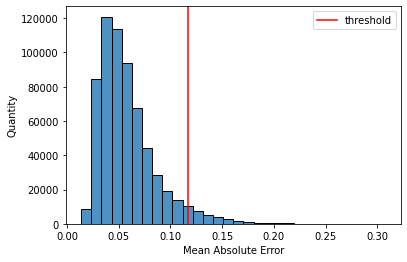

In [43]:
predictions = my_autoencoder_lstm_model.predict(x_test_h_dim)
prediction_loss = keras.losses.mae(np.reshape(predictions, (-1, 77)), np.reshape(x_test_h_dim, (-1, 77)))
threshold = np.percentile(prediction_loss, 100-percetage)
print('The threshold is: ', threshold)
sns.histplot(prediction_loss, bins=30, alpha=0.8)
plt.axvline(x=threshold, color='red', label='threshold')
plt.ylabel('Quantity')
plt.xlabel('Mean Absolute Error')
plt.legend()
plt.show()

Prediction Report
               precision    recall  f1-score   support

           0       0.96      0.96      0.96    600134
           1       0.05      0.05      0.05     28207

    accuracy                           0.91    628341
   macro avg       0.50      0.50      0.50    628341
weighted avg       0.91      0.91      0.91    628341



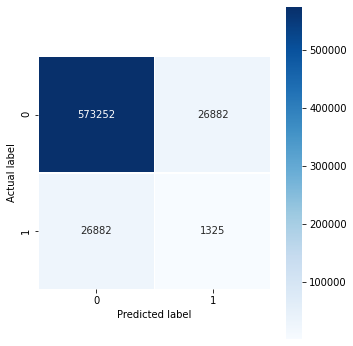

In [57]:
prediction_label = [0 if x < threshold else 1 for x in prediction_loss]
print("Prediction Report\n", classification_report(y_test, prediction_label))
cm = confusion_matrix(y_test, prediction_label)
plt.figure(figsize=(5,5))
sns.heatmap(data=cm, linewidths=.5, annot=True, square = True, cmap = 'Blues', fmt='d')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

In [16]:
# rnn

my_autoencoder_rnn_model = keras.Sequential()
my_autoencoder_rnn_model.add(keras.layers.SimpleRNN(48, input_shape=(7, 11), return_sequences=False))
my_autoencoder_rnn_model.add(keras.layers.RepeatVector(7))
my_autoencoder_rnn_model.add(keras.layers.SimpleRNN(48, return_sequences=True))
my_autoencoder_rnn_model.add(keras.layers.TimeDistributed(keras.layers.Dense(11)))

my_autoencoder_rnn_model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001), 
    loss=keras.losses.MeanAbsoluteError()
)

In [20]:
callback = keras.callbacks.EarlyStopping(monitor='loss', patience=3)

In [21]:
my_autoencoder_rnn_model.fit(
    x_train_h_dim, x_train_h_dim,
    epochs = 10,
    batch_size = 64,
    callbacks = [callback],
    validation_data = (x_test_h_dim, x_test_h_dim)
) # 20 epochs in total

Epoch 1/10
21880/21880 [==============================] - 740s 34ms/step - loss: 0.0241 - val_loss: 0.0241
Epoch 2/10
21880/21880 [==============================] - 800s 37ms/step - loss: 0.0239 - val_loss: 0.0243
Epoch 3/10
21880/21880 [==============================] - 903s 41ms/step - loss: 0.0235 - val_loss: 0.0229
Epoch 4/10
21880/21880 [==============================] - 913s 42ms/step - loss: 0.0231 - val_loss: 0.0240
Epoch 5/10
21880/21880 [==============================] - 880s 40ms/step - loss: 0.0228 - val_loss: 0.0226
Epoch 6/10
21880/21880 [==============================] - 890s 41ms/step - loss: 0.0227 - val_loss: 0.0225
Epoch 7/10
21880/21880 [==============================] - 912s 42ms/step - loss: 0.0226 - val_loss: 0.0219
Epoch 8/10
21880/21880 [==============================] - 899s 41ms/step - loss: 0.0224 - val_loss: 0.0229
Epoch 9/10
21880/21880 [==============================] - 895s 41ms/step - loss: 0.0224 - val_loss: 0.0229
Epoch 10/10
21880/21880 [============

The threshold is:  0.0493077588026159


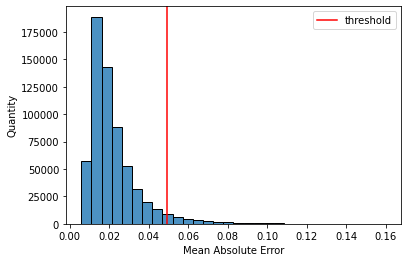

In [22]:
predictions = my_autoencoder_rnn_model.predict(x_test_h_dim)
prediction_loss = keras.losses.mae(np.reshape(predictions, (-1, 77)), np.reshape(x_test_h_dim, (-1, 77)))
threshold = np.percentile(prediction_loss, 100-percetage)
print('The threshold is: ', threshold)
sns.histplot(prediction_loss, bins=30, alpha=0.8)
plt.axvline(x=threshold, color='red', label='threshold')
plt.ylabel('Quantity')
plt.xlabel('Mean Absolute Error')
plt.legend()
plt.show()

Prediction Report
               precision    recall  f1-score   support

           0       0.96      0.96      0.96    600134
           1       0.06      0.06      0.06     28207

    accuracy                           0.92    628341
   macro avg       0.51      0.51      0.51    628341
weighted avg       0.92      0.92      0.92    628341



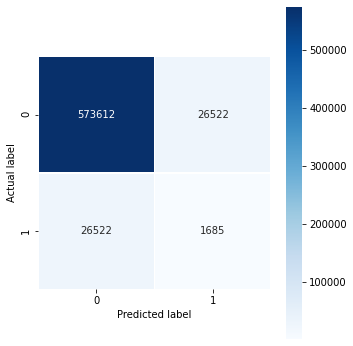

In [28]:
prediction_label = [0 if x < threshold else 1 for x in prediction_loss]
print("Prediction Report\n", classification_report(y_test, prediction_label))
cm = confusion_matrix(y_test, prediction_label)
plt.figure(figsize=(5,5))
sns.heatmap(data=cm, linewidths=.5, annot=True, square = True, cmap = 'Blues', fmt='d')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()